In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
from scipy import stats as st
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import graphviz
import time
import math
from sklearn.model_selection import train_test_split

In [2]:
nfl = pd.read_csv("nfl_fg.csv")

In [3]:
nfl = nfl.drop("Unnamed: 0", axis=1)

In [4]:
nfl.dtypes

gameId                      int64
playId                      int64
playDescription            object
quarter                     int64
down                        int64
yardsToGo                   int64
possessionTeam             object
specialTeamsPlayType       object
specialTeamsResult         object
kickerId                  float64
returnerId                float64
kickBlockerId             float64
yardlineSide               object
yardlineNumber              int64
gameClock                  object
penaltyCodes               object
penaltyJerseyNumbers       object
penaltyYards              float64
preSnapHomeScore            int64
preSnapVisitorScore         int64
passResult                 object
kickLength                float64
kickReturnYardage         float64
playResult                  int64
absoluteYardlineNumber      int64
distance                  float64
result                      int64
seconds                     int64
season                      int64
week          

In [5]:
nfl.displayName = nfl.displayName.astype("category")
nfl.homeTeamAbbr = nfl.homeTeamAbbr.astype("category")

In [6]:
nfl.displayName

0            Matt Bryant
1           Jake Elliott
2            Matt Bryant
3          Justin Tucker
4       Stephen Hauschka
              ...       
2652         Jason Myers
2653         Jason Myers
2654    Tristan Vizcaino
2655    Tristan Vizcaino
2656    Tristan Vizcaino
Name: displayName, Length: 2657, dtype: category
Categories (59, object): ['Adam Vinatieri', 'Aldrick Rosas', 'Austin Seibert', 'Brandon McManus', ..., 'Tyler Bass', 'Wil Lutz', 'Younghoe Koo', 'Zane Gonzalez']

In [7]:
nfl = nfl.dropna(subset=["distance"])
nfl = nfl.reset_index()

In [8]:
nfl.seconds = nfl.seconds.astype("float")
# add constant to account for any. 0 values
nfl.seconds = nfl.seconds + 0.001
nfl.seconds = np.log10(nfl.seconds)
nfl.seconds

0       3.477555
1       3.336860
2       3.286232
3       3.414639
4       3.366983
          ...   
2636    3.452247
2637    3.374932
2638    3.262214
2639    3.169087
2640    3.108227
Name: seconds, Length: 2641, dtype: float64

In [9]:
home_teams = pd.get_dummies(nfl.homeTeamAbbr)
kickers = pd.get_dummies(nfl.displayName)

In [10]:
# standardize

X = nfl[["distance", "seconds", "score_diff"]]
mnX = X.mean().values
stdX = X.std().values
zX = pd.DataFrame(((X - mnX) / stdX).values)

cols = ["distance", "seconds", "diff"]
zX.columns = cols
zX.head()

X = pd.concat([zX, home_teams, kickers], axis=1)
y = nfl["result"]

In [11]:
name = nfl.displayName.values
names = len(nfl.displayName.unique())
name_lookup = dict(zip(nfl.displayName.unique(), range(names)))
name = nfl.displayName.replace(name_lookup).values

distance = nfl.distance.values

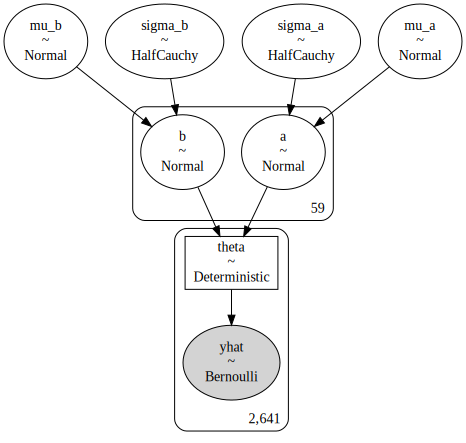

In [12]:
# TO-DO: multilevel model

with pm.Model() as hierarchical_model:
    
    # priors
    mu_a = pm.Normal("mu_a", mu = 0, sd = 1e5)
    sigma_a = pm.HalfCauchy("sigma_a", 10)
    mu_b = pm.Normal("mu_b", mu = 0, sd = 1e5)
    sigma_b = pm.HalfCauchy("sigma_b", 10)
    
    # random intercepts
    a = pm.Normal("a", mu = mu_a, sd = sigma_a, shape = names)
    
    # random slopes
    b = pm.Normal("b", mu = mu_b, sd = sigma_b, shape = names)
    
    # expected
    u = a[name] + (b[name] * distance)
    theta = pm.Deterministic("theta", pm.invlogit(u))
    
    yhat = pm.Bernoulli('yhat', p = theta, observed = y)

pm.model_to_graphviz(hierarchical_model)

In [13]:
with hierarchical_model:
    hierarchical_trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 90 seconds.
There were 4708 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.0896728821601573e-07, but should be close to 0.8. Try to increase the number of tuning steps.
There were 821 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6956916423665318, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


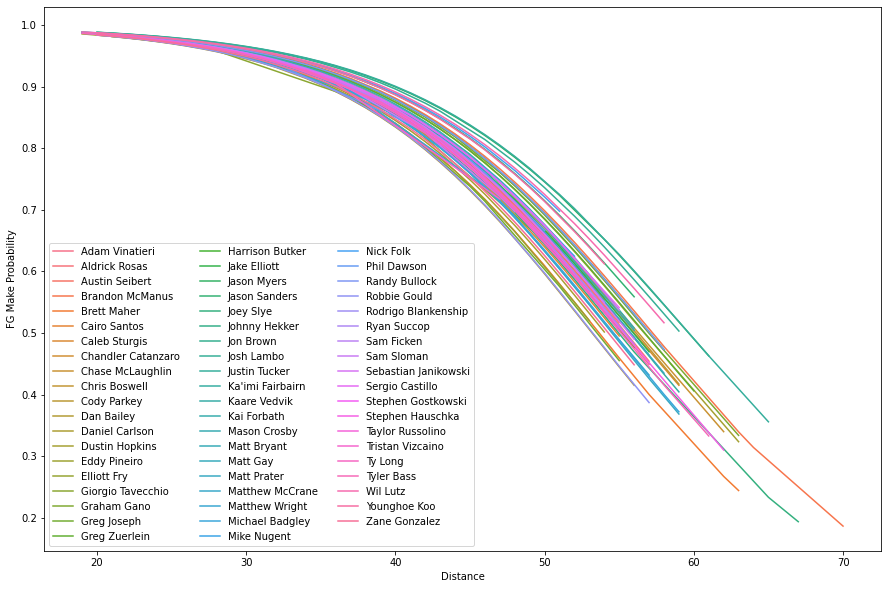

In [14]:
plt.figure(figsize = (15, 10))
sns.lineplot(x = nfl['distance'], y = hierarchical_trace.theta.mean(axis=0),
               hue = nfl['displayName'])
plt.plot();
plt.xlabel('Distance')
plt.ylabel('FG Make Probability')
plt.legend(ncol = 3)

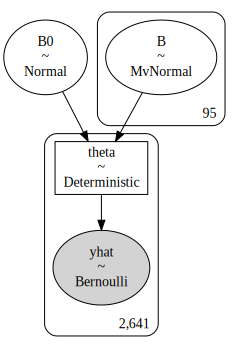

In [15]:
with pm.Model() as model:
    
    B0 = pm.Normal("B0", mu = 0, sd = 1e5)
    B = pm.MvNormal("B", mu = np.zeros(95), cov = np.eye(95) * 1e5, shape = 95)  
    
    u = B0 + pm.math.dot(X, B)
    theta = pm.Deterministic("theta", pm.invlogit(u))
    
    yhat = pm.Bernoulli("yhat", p = theta, observed = y)

pm.model_to_graphviz(model)

In [16]:
with model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [B, B0]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 74 seconds.
There were 4808 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4648 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


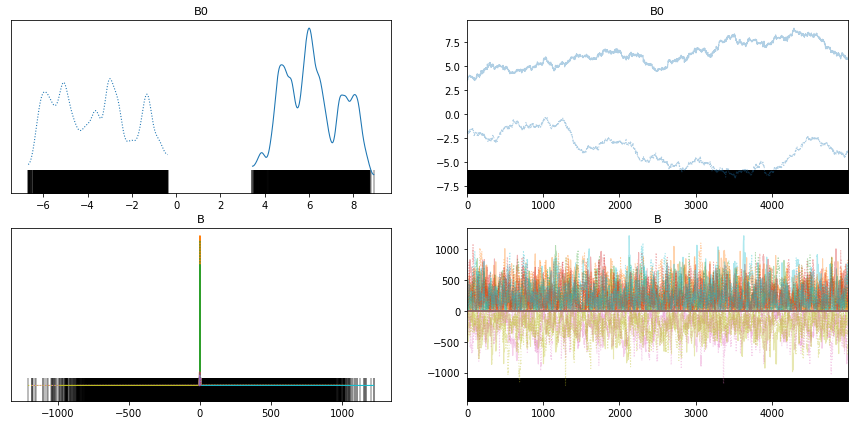

In [17]:
with model:
    az.plot_trace(trace, var_names=['B0', 'B'], figsize=(15, 7));

In [18]:
with model:
    print(pm.summary(trace, var_names=['B0', 'B']))

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
B0     1.231  5.150  -6.158    8.113      3.577    3.007       2.0      22.0   
B[0]  -1.331  0.080  -1.484   -1.179      0.004    0.003     498.0     777.0   
B[1]   0.032  0.060  -0.085    0.142      0.003    0.002     488.0     840.0   
B[2]  -0.069  0.065  -0.190    0.053      0.004    0.003     329.0     768.0   
B[3]   1.212  3.535  -3.191    6.435      2.426    2.029       3.0      38.0   
...      ...    ...     ...      ...        ...      ...       ...       ...   
B[90] -0.406  2.021  -4.161    3.033      1.202    0.958       3.0      19.0   
B[91] -0.816  1.860  -3.937    2.519      1.187    0.966       3.0      14.0   
B[92]  0.099  1.825  -3.017    3.180      1.202    0.989       2.0      13.0   
B[93]  0.172  1.865  -3.141    3.393      1.196    0.975       3.0      13.0   
B[94] -0.683  1.820  -3.662    2.602      1.202    0.990       2.0      13.0   

       r_hat  
B0      2.50  
B[0]    1

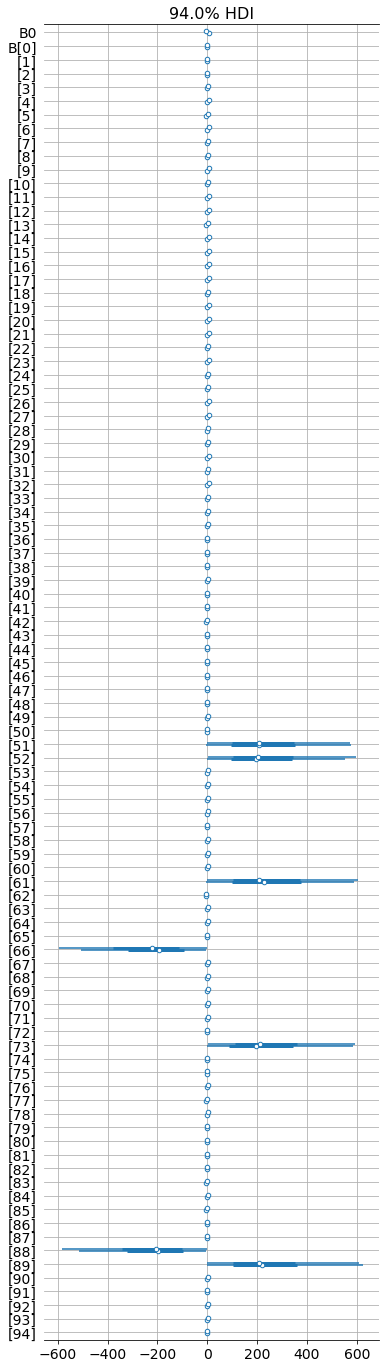

In [19]:
with model:
    pm.plots.plot_forest(trace, var_names=['B0', 'B'])
    plt.grid()

Finished [100%]: Average Loss = 1,540.9


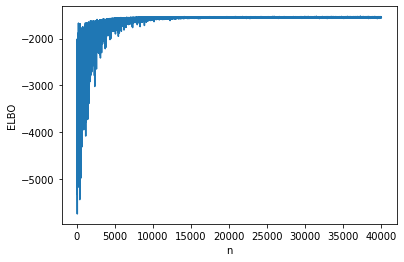

In [20]:
with model:
    approx = pm.fit(40000, method = 'advi', random_seed = 100)
    sample_advi = approx.sample(1000)

advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

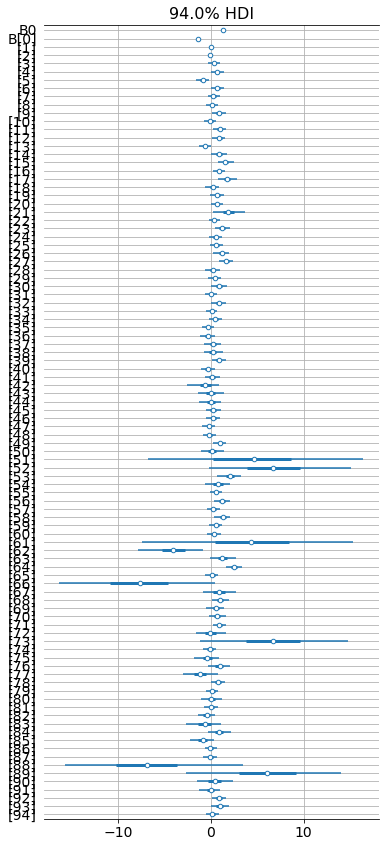

In [21]:
with model:
    pm.plots.plot_forest(sample_advi, var_names=['B0', 'B'])
    plt.grid()

In [22]:
# Predicition accuracy
# Train/Test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

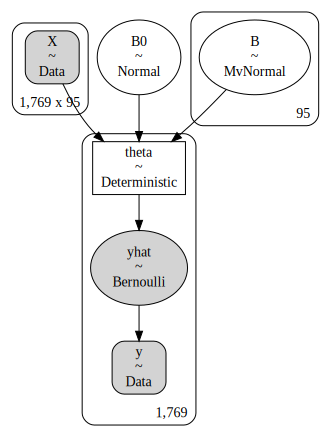

In [47]:
def construct_bayes_regression(model_input, model_output):
    with pm.Model() as bayes_model:
        
        X = pm.Data('X', model_input)
        y = pm.Data('y', model_output)

        B0 = pm.Normal('B0', mu = 0, sd = 1e5)
        B = pm.MvNormal('B', mu = np.zeros(95), cov = np.eye(95) * 1e5, shape = 95)  

        u = B0 + pm.math.dot(X, B)
        theta = pm.Deterministic('theta', pm.invlogit(u))

        yhat = pm.Bernoulli('yhat', p = theta, observed = y)
        
    return bayes_model

bayes_model = construct_bayes_regression(X_train, y_train)
pm.model_to_graphviz(bayes_model)

Finished [100%]: Average Loss = 1,175.5


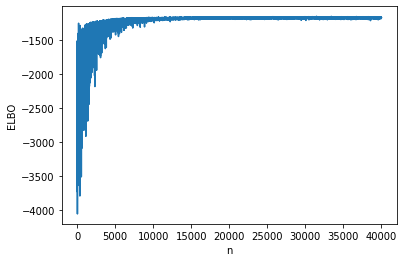

In [25]:
with bayes_model:
    approx = pm.fit(40000, method = 'advi', random_seed = 100)
    sample_advi = approx.sample(1000)

advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [26]:
pm.set_data({'X': X_test, 'y': y_test}, model = bayes_model)

In [27]:
with bayes_model:
    fg_predictions = pm.sample_posterior_predictive(sample_advi, samples=1000, progressbar=False)

yhat = fg_predictions['yhat'].mean(axis=0) > 0.5

In [28]:
print('Accuracy = {}%'.format((y_test == yhat).mean() * 100))

Accuracy = 80.96330275229357%


## Multilevel modeling

In [29]:
name = nfl.displayName.values
names = len(nfl.displayName.unique())
name_lookup = dict(zip(nfl.displayName.unique(), range(names)))
name = nfl.displayName.replace(name_lookup).values

In [31]:
stadium = nfl.homeTeamAbbr.values
stadiums = len(nfl.homeTeamAbbr.unique())
stadium_lookup = dict(zip(nfl.homeTeamAbbr.unique(), range(stadiums)))
stadium = nfl.homeTeamAbbr.replace(stadium_lookup).values

In [33]:
name_train, name_test, stadium_train, stadium_test, y_train, y_test, distance_train, distance_test = train_test_split(name, stadium, y, distance, test_size = 0.33, random_state = 42)

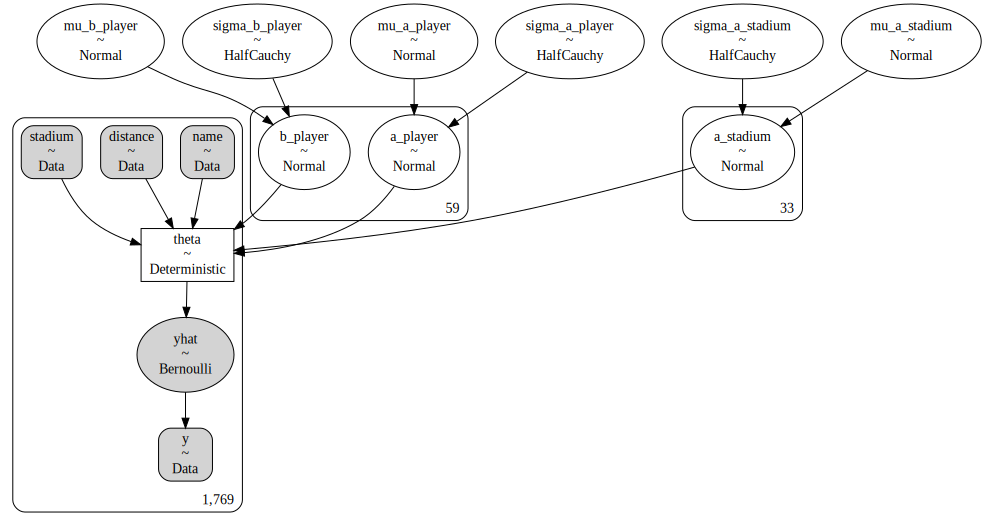

In [46]:
def construct_multilevel_regression(name_input, stadium_input, distance_input, model_output):
    with pm.Model() as multilevel_model:   
        
        name = pm.Data('name', name_input)
        stadium = pm.Data('stadium', stadium_input)
        distance = pm.Data('distance', distance_input)
        y = pm.Data('y', model_output)       

        # priors
        mu_a_player = pm.Normal("mu_a_player", mu = 0, sd = 1e5)
        sigma_a_player = pm.HalfCauchy("sigma_a_player", 10)
        mu_b_player = pm.Normal("mu_b_player", mu = 0, sd = 1e5)
        sigma_b_player = pm.HalfCauchy("sigma_b_player", 10)


        # random intercepts
        a_player = pm.Normal("a_player", mu = mu_a_player, sd = sigma_a_player, shape = names)

        # random slopes
        b_player = pm.Normal("b_player", mu = mu_b_player, sd = sigma_b_player, shape = names)

        # priors
        mu_a_stadium = pm.Normal("mu_a_stadium", mu = 0, sd = 1e5)
        sigma_a_stadium = pm.HalfCauchy("sigma_a_stadium", 10)
        # mu_b_stadium = pm.Normal("mu_b_stadium", mu = 0, sd = 1e5)
        # sigma_b_stadium = pm.HalfCauchy("sigma_b_stadium", 10)

        # random intercepts
        a_stadium = pm.Normal("a_stadium", mu = mu_a_stadium, sd = sigma_a_stadium, shape = stadiums)

        # random slopes
        # b_stadium = pm.Normal("b_stadium", mu = mu_b_stadium, sd = sigma_b_stadium, shape = stadiums)

        u = a_player[name] + (b_player[name] * distance)  + a_stadium[stadium] + (a_stadium[stadium] * a_player[name])


        theta = pm.Deterministic("theta", pm.invlogit(u))

        yhat = pm.Bernoulli('yhat', p = theta, observed = y)
        
    return multilevel_model

multilevel_model = construct_multilevel_regression(name_train, stadium_train, distance_train, y_train)
pm.model_to_graphviz(multilevel_model)

Finished [100%]: Average Loss = 828.2


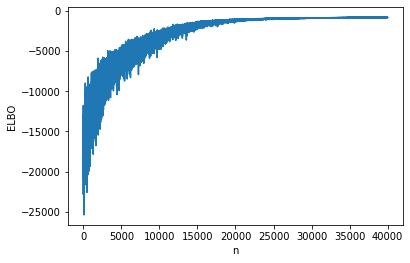

In [36]:
with multilevel_model:
    approx = pm.fit(40000, method = 'advi', random_seed = 100)
    sample_advi = approx.sample(1000)

advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [37]:
pm.set_data({'name': name_test, 
             'stadium': stadium_test, 
             'distance': distance_test, 
             'y': y_test}, 
            model = multilevel_model)      

In [ ]:
with multilevel_model:
    fg_predictions = pm.sample_posterior_predictive(sample_advi, samples=1000, progressbar=False)

yhat = fg_predictions['yhat'].mean(axis=0) > 0.5

In [48]:
print('Accuracy = {}%'.format((y_test == yhat).mean() * 100))

Accuracy = 82.56880733944955%


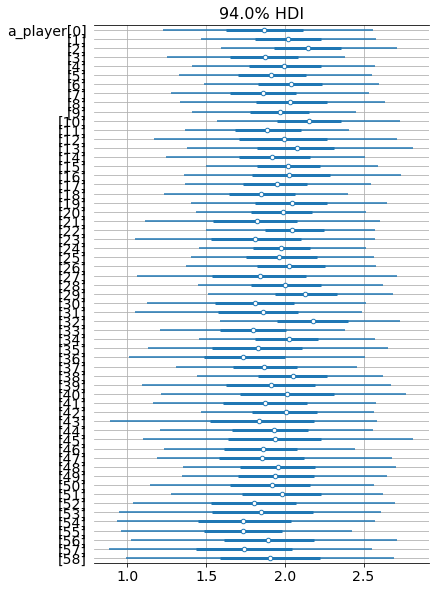

In [50]:
with multilevel_model:
    pm.plots.plot_forest(sample_advi, var_names=['a_player'])
    plt.grid()